# Spaceship Titanic
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

In [7]:
# Import Development Dependencies
import os
os.environ['LDFLAGS'] = "-L/opt/homebrew/opt/libomp/lib"
os.environ['CPPFLAGS'] = "-I/opt/homebrew/opt/libomp/include"

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Load the data
df_test  = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')  

## Explore the Data

In [9]:
# Get info of the training data
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   str    
 1   HomePlanet    8492 non-null   str    
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   str    
 4   Destination   8511 non-null   str    
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   str    
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(2), str(5)
memory usage: 891.5+ KB


In [10]:
# Get shape of the training data
df_train.shape

(8693, 14)

In [11]:
# Get data types of the training data
df_train.dtypes

PassengerId         str
HomePlanet          str
CryoSleep        object
Cabin               str
Destination         str
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name                str
Transported        bool
dtype: object

In [12]:
# Preview the training data
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


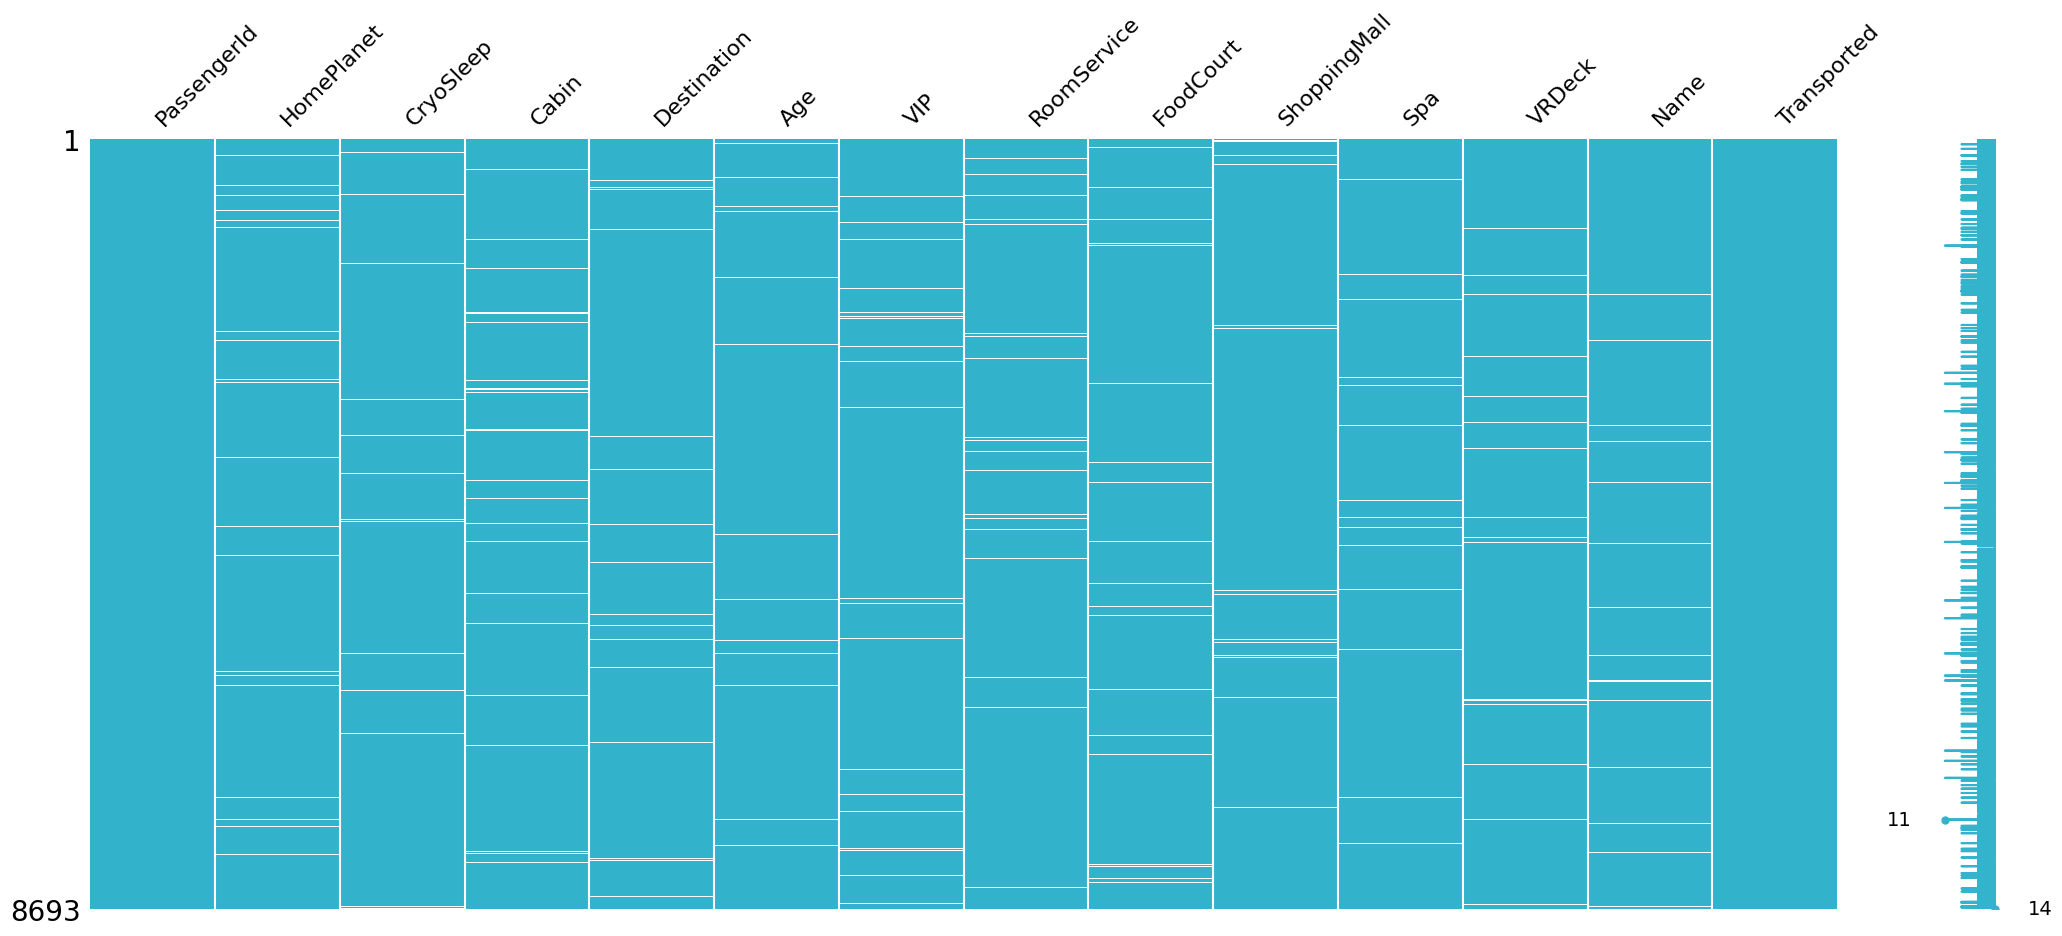

In [13]:
# visualize all columns in training data
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
msno.matrix(df_train, color=(0.2, 0.7, 0.8))
plt.show()

## Clean the Data

## Find duplicates

In [14]:
# find duplicates in training data
df_train.duplicated().sum()

np.int64(0)

In [15]:
# find duplicate rows in test data
df_test.duplicated().sum()

np.int64(0)

### Find missing values

In [16]:
# find any missing values in training data
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [17]:
# find any missing values in test data
df_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

### Handle Missing Values

In [18]:
# Handle missing values for categorical columns using mode imputation
categorical_cols = ['HomePlanet', 'Destination', 'VIP', 'CryoSleep']

for col in categorical_cols:
    # Fill training data
    mode_val = df_train[col].mode()[0]
    df_train[col] = df_train[col].fillna(mode_val)
    
    # Fill test data with training mode (to avoid data leakage)
    df_test[col] = df_test[col].fillna(mode_val)

print("Categorical missing values handled")

Categorical missing values handled


In [19]:
# Handle Age missing values with median imputation
age_median = df_train['Age'].median()
df_train['Age'] = df_train['Age'].fillna(age_median)
df_test['Age'] = df_test['Age'].fillna(age_median)

print(f"Age missing values filled with median: {age_median}")

Age missing values filled with median: 27.0


In [20]:
# Handle expenditure columns missing values with 0 (assuming missing = no spending)
expenditure_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for col in expenditure_cols:
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)

print("Expenditure missing values filled with 0")

Expenditure missing values filled with 0


In [21]:
# Handle Cabin missing values with placeholder (will be parsed later)
df_train['Cabin'] = df_train['Cabin'].fillna('Unknown/0/Unknown')
df_test['Cabin'] = df_test['Cabin'].fillna('Unknown/0/Unknown')

# Drop Name column as it's not immediately useful for prediction
df_train = df_train.drop('Name', axis=1)
df_test = df_test.drop('Name', axis=1)

print("Cabin filled with placeholder, Name column dropped")

Cabin filled with placeholder, Name column dropped


In [22]:
# Verify that all missing values have been handled
print("Training data missing values:")
print(df_train.isnull().sum())
print("\nTest data missing values:")
print(df_test.isnull().sum())
print("\nData shapes after cleaning:")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

Training data missing values:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64

Test data missing values:
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
dtype: int64

Data shapes after cleaning:
Train: (8693, 13)
Test: (4277, 12)


## Feature Engineering

In [53]:
# Parse Cabin into Deck, Number, and Side
def parse_cabin(cabin_str):
    if cabin_str == 'Unknown/0/Unknown':
        return 'Unknown', 0, 'Unknown'
    try:
        deck, num, side = cabin_str.split('/')
        return deck, int(num), side
    except:
        return 'Unknown', 0, 'Unknown'

# Apply to both datasets
df_train[['Deck', 'Cabin_Num', 'Side']] = df_train['Cabin'].apply(lambda x: pd.Series(parse_cabin(x)))
df_test[['Deck', 'Cabin_Num', 'Side']] = df_test['Cabin'].apply(lambda x: pd.Series(parse_cabin(x)))

print("Cabin parsed into Deck, Cabin_Num, and Side")

KeyError: 'Cabin'

In [24]:
# Parse PassengerId into Group and Person number
df_train[['Group', 'Person']] = df_train['PassengerId'].str.split('_', expand=True).astype(int)
df_test[['Group', 'Person']] = df_test['PassengerId'].str.split('_', expand=True).astype(int)

# Calculate group size (number of people in each group)
group_sizes_train = df_train.groupby('Group')['Person'].count().reset_index()
group_sizes_train.columns = ['Group', 'Group_Size']
df_train = df_train.merge(group_sizes_train, on='Group', how='left')

group_sizes_test = df_test.groupby('Group')['Person'].count().reset_index()
group_sizes_test.columns = ['Group', 'Group_Size']
df_test = df_test.merge(group_sizes_test, on='Group', how='left')

print("PassengerId parsed into Group and Person, Group_Size calculated")

PassengerId parsed into Group and Person, Group_Size calculated


In [25]:
# Create expenditure features
expenditure_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Total expenditure
df_train['Total_Expenditure'] = df_train[expenditure_cols].sum(axis=1)
df_test['Total_Expenditure'] = df_test[expenditure_cols].sum(axis=1)

# Luxury vs Basic spending (Spa and VRDeck are luxury, others are basic)
luxury_cols = ['Spa', 'VRDeck']
basic_cols = ['RoomService', 'FoodCourt', 'ShoppingMall']

df_train['Luxury_Expenditure'] = df_train[luxury_cols].sum(axis=1)
df_train['Basic_Expenditure'] = df_train[basic_cols].sum(axis=1)

df_test['Luxury_Expenditure'] = df_test[luxury_cols].sum(axis=1)
df_test['Basic_Expenditure'] = df_test[basic_cols].sum(axis=1)

# Spending indicator (whether passenger spent any money)
df_train['Has_Spent'] = (df_train['Total_Expenditure'] > 0).astype(int)
df_test['Has_Spent'] = (df_test['Total_Expenditure'] > 0).astype(int)

print("Expenditure features created: Total_Expenditure, Luxury_Expenditure, Basic_Expenditure, Has_Spent")

Expenditure features created: Total_Expenditure, Luxury_Expenditure, Basic_Expenditure, Has_Spent


In [26]:
# Create age groups
def categorize_age(age):
    if age <= 12:
        return 'Child'
    elif age <= 18:
        return 'Teen'
    elif age <= 35:
        return 'Young_Adult'
    elif age <= 60:
        return 'Adult'
    else:
        return 'Senior'

df_train['Age_Group'] = df_train['Age'].apply(categorize_age)
df_test['Age_Group'] = df_test['Age'].apply(categorize_age)

print("Age groups created: Child, Teen, Young_Adult, Adult, Senior")

Age groups created: Child, Teen, Young_Adult, Adult, Senior


In [51]:
# Ensure boolean columns are properly typed
df_train['CryoSleep'] = df_train['CryoSleep'].astype(bool)
df_train['VIP'] = df_train['VIP'].astype(bool)
df_train['Transported'] = df_train['Transported'].astype(bool)

df_test['CryoSleep'] = df_test['CryoSleep'].astype(bool)
df_test['VIP'] = df_test['VIP'].astype(bool)

# Drop original Cabin column since we've parsed it
df_train = df_train.drop('Cabin', axis=1)
df_test = df_test.drop('Cabin', axis=1)

print("Data types corrected and Cabin column dropped")
print(f"\nFinal training data shape: {df_train.shape}")
print(f"Final test data shape: {df_test.shape}")
print("\nNew features created:")
print("- Deck, Cabin_Num, Side (from Cabin)")
print("- Group, Person, Group_Size (from PassengerId)")
print("- Total_Expenditure, Luxury_Expenditure, Basic_Expenditure, Has_Spent")
print("- Age_Group")

Data types corrected and Cabin column dropped

Final training data shape: (8693, 13)
Final test data shape: (4277, 12)

New features created:
- Deck, Cabin_Num, Side (from Cabin)
- Group, Person, Group_Size (from PassengerId)
- Total_Expenditure, Luxury_Expenditure, Basic_Expenditure, Has_Spent
- Age_Group


## Outlier Detection & Treatment

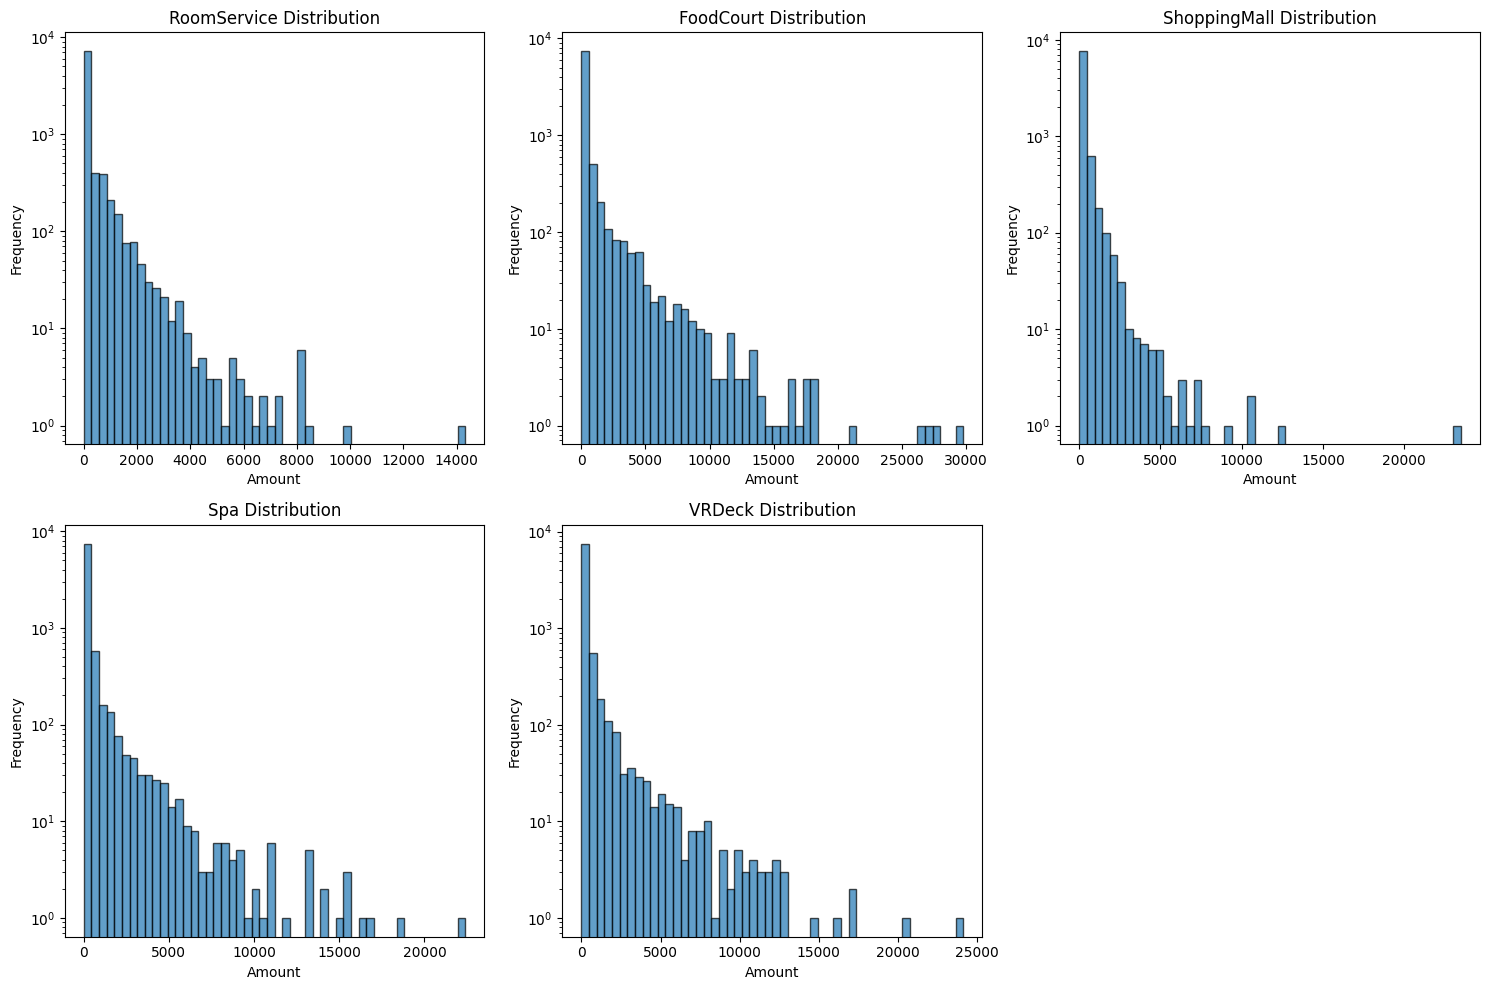

Expenditure columns summary statistics:
        RoomService     FoodCourt  ShoppingMall           Spa        VRDeck
count   8693.000000   8693.000000   8693.000000   8693.000000   8693.000000
mean     220.009318    448.434027    169.572300    304.588865    298.261820
std      660.519050   1595.790627    598.007164   1125.562559   1134.126417
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%       41.000000     61.000000     22.000000     53.000000     40.000000
max    14327.000000  29813.000000  23492.000000  22408.000000  24133.000000


In [28]:
# Visualize expenditure distributions to identify outliers
expenditure_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

plt.figure(figsize=(15, 10))
for i, col in enumerate(expenditure_cols, 1):
    plt.subplot(2, 3, i)
    plt.hist(df_train[col], bins=50, alpha=0.7, edgecolor='black')
    plt.title(f'{col} Distribution')
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.yscale('log')  # Log scale to see the distribution better

plt.tight_layout()
plt.show()

# Check summary statistics for expenditure columns
print("Expenditure columns summary statistics:")
print(df_train[expenditure_cols].describe())

In [29]:
# Detect and treat outliers in expenditure columns using IQR method
def cap_outliers_iqr(df, columns, factor=1.5):
    """
    Cap outliers using IQR method
    factor: multiplier for IQR (typically 1.5 or 3)
    """
    df_capped = df.copy()
    for col in columns:
        # Only consider non-zero values for outlier detection
        non_zero_values = df_capped[df_capped[col] > 0][col]

        if len(non_zero_values) > 0:
            Q1 = non_zero_values.quantile(0.25)
            Q3 = non_zero_values.quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR

            # Cap values above upper bound
            df_capped[col] = df_capped[col].clip(upper=upper_bound)

            print(f"{col}: Q1={Q1:.2f}, Q3={Q3:.2f}, IQR={IQR:.2f}")
            print(f"  Capped {len(df_capped[df_capped[col] == upper_bound])} values at {upper_bound:.2f}")

    return df_capped

# Apply outlier capping to expenditure columns
print("Applying outlier treatment to expenditure columns...")
df_train = cap_outliers_iqr(df_train, expenditure_cols)
df_test = cap_outliers_iqr(df_test, expenditure_cols)

print("\nOutlier treatment completed for expenditure columns")

Applying outlier treatment to expenditure columns...
RoomService: Q1=37.00, Q3=848.00, IQR=811.00
  Capped 191 values at 2064.50
FoodCourt: Q1=39.00, Q3=1255.75, IQR=1216.75
  Capped 384 values at 3080.88
ShoppingMall: Q1=22.00, Q3=693.00, IQR=671.00
  Capped 176 values at 1699.50
Spa: Q1=27.00, Q3=769.00, IQR=742.00
  Capped 358 values at 1882.00
VRDeck: Q1=28.00, Q3=806.50, IQR=778.50
  Capped 325 values at 1974.25
RoomService: Q1=38.00, Q3=879.00, IQR=841.00
  Capped 85 values at 2140.50
FoodCourt: Q1=47.00, Q3=1220.00, IQR=1173.00
  Capped 170 values at 2979.50
ShoppingMall: Q1=25.50, Q3=706.00, IQR=680.50
  Capped 85 values at 1726.75
Spa: Q1=23.00, Q3=781.00, IQR=758.00
  Capped 158 values at 1918.00
VRDeck: Q1=29.00, Q3=808.25, IQR=779.25
  Capped 170 values at 1977.12

Outlier treatment completed for expenditure columns


In [30]:
# Check for outliers in Age
print("Age statistics:")
print(df_train['Age'].describe())

# Check for unrealistic age values
unrealistic_ages = df_train[(df_train['Age'] < 0) | (df_train['Age'] > 120)]
if len(unrealistic_ages) > 0:
    print(f"\nFound {len(unrealistic_ages)} unrealistic age values")
else:
    print("\nNo unrealistic age values found")

# Check Cabin_Num for logical values
print(f"\nCabin_Num statistics:")
print(df_train['Cabin_Num'].describe())

# Check for logical consistency: CryoSleep passengers should not have expenditures
cryo_with_spending = df_train[(df_train['CryoSleep'] == True) & (df_train['Total_Expenditure'] > 0)]
if len(cryo_with_spending) > 0:
    print(f"\nFound {len(cryo_with_spending)} CryoSleep passengers with spending - correcting to 0")
    # Set expenditures to 0 for CryoSleep passengers
    expenditure_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in expenditure_cols:
        df_train.loc[df_train['CryoSleep'] == True, col] = 0
        df_test.loc[df_test['CryoSleep'] == True, col] = 0

    # Recalculate expenditure features
    df_train['Total_Expenditure'] = df_train[expenditure_cols].sum(axis=1)
    df_train['Luxury_Expenditure'] = df_train[['Spa', 'VRDeck']].sum(axis=1)
    df_train['Basic_Expenditure'] = df_train[['RoomService', 'FoodCourt', 'ShoppingMall']].sum(axis=1)
    df_train['Has_Spent'] = (df_train['Total_Expenditure'] > 0).astype(int)

    df_test['Total_Expenditure'] = df_test[expenditure_cols].sum(axis=1)
    df_test['Luxury_Expenditure'] = df_test[['Spa', 'VRDeck']].sum(axis=1)
    df_test['Basic_Expenditure'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall']].sum(axis=1)
    df_test['Has_Spent'] = (df_test['Total_Expenditure'] > 0).astype(int)

print("\nData consistency checks completed")

Age statistics:
count    8693.000000
mean       28.790291
std        14.341404
min         0.000000
25%        20.000000
50%        27.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64

No unrealistic age values found

Cabin_Num statistics:
count    8693.000000
mean      586.624065
std       513.880084
min         0.000000
25%       152.000000
50%       407.000000
75%       983.000000
max      1894.000000
Name: Cabin_Num, dtype: float64

Data consistency checks completed


In [31]:
# Final verification after outlier treatment
print("Final dataset shapes:")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")

print("\nFinal expenditure statistics after outlier treatment:")
print(df_train[expenditure_cols].describe())

print("\nData types:")
print(df_train.dtypes)

# Quick check that everything looks good
print(f"\nNull values remaining: {df_train.isnull().sum().sum()}")
print(f"Duplicate rows: {df_train.duplicated().sum()}")

print("\nOutlier detection and treatment completed successfully!")

Final dataset shapes:
Train: (8693, 23)
Test: (4277, 22)

Final expenditure statistics after outlier treatment:
       RoomService    FoodCourt  ShoppingMall          Spa       VRDeck
count  8693.000000  8693.000000   8693.000000  8693.000000  8693.000000
mean    187.692454   302.087427    141.831013   193.311515   191.178218
std     449.907113   749.924572    353.842785   461.516650   468.303671
min       0.000000     0.000000      0.000000     0.000000     0.000000
25%       0.000000     0.000000      0.000000     0.000000     0.000000
50%       0.000000     0.000000      0.000000     0.000000     0.000000
75%      41.000000    61.000000     22.000000    53.000000    40.000000
max    2064.500000  3080.875000   1699.500000  1882.000000  1974.250000

Data types:
PassengerId               str
HomePlanet                str
CryoSleep                bool
Destination               str
Age                   float64
VIP                      bool
RoomService           float64
FoodCourt        

## Data Consistency Checks

In [32]:
# Check cabin logic: cabins should have reasonable numbering within decks
print("Cabin numbering analysis by deck:")
for deck in sorted(df_train['Deck'].unique()):
    if deck != 'Unknown':
        deck_data = df_train[df_train['Deck'] == deck]
        cabin_nums = deck_data['Cabin_Num']
        print(f"Deck {deck}: {len(cabin_nums)} cabins, numbers range: {cabin_nums.min()} - {cabin_nums.max()}")

# Check for unusual cabin numbering patterns
unusual_cabins = df_train[
    (df_train['Deck'] != 'Unknown') &
    ((df_train['Cabin_Num'] < 0) | (df_train['Cabin_Num'] > 2000))
]
if len(unusual_cabins) > 0:
    print(f"\nFound {len(unusual_cabins)} cabins with unusual numbering")
else:
    print("\nNo unusual cabin numbering found")

Cabin numbering analysis by deck:
Deck A: 256 cabins, numbers range: 0 - 107
Deck B: 779 cabins, numbers range: 0 - 353
Deck C: 747 cabins, numbers range: 0 - 342
Deck D: 478 cabins, numbers range: 0 - 295
Deck E: 876 cabins, numbers range: 0 - 608
Deck F: 2794 cabins, numbers range: 0 - 1894
Deck G: 2559 cabins, numbers range: 0 - 1508
Deck T: 5 cabins, numbers range: 0 - 3

No unusual cabin numbering found


In [33]:
# Check group consistency: passengers in same group should have same HomePlanet and Destination
def check_group_consistency(df, column):
    """Check if all passengers in a group have the same value for a column"""
    group_consistency = df.groupby('Group')[column].nunique()
    inconsistent_groups = group_consistency[group_consistency > 1]
    return len(inconsistent_groups), inconsistent_groups.index.tolist()

# Check HomePlanet consistency within groups
inconsistent_homeplanet, homeplanet_groups = check_group_consistency(df_train, 'HomePlanet')
print(f"Groups with inconsistent HomePlanet: {inconsistent_homeplanet}")
if inconsistent_homeplanet > 0:
    print(f"Inconsistent groups: {homeplanet_groups[:5]}...")  # Show first 5

# Check Destination consistency within groups
inconsistent_destination, destination_groups = check_group_consistency(df_train, 'Destination')
print(f"Groups with inconsistent Destination: {inconsistent_destination}")
if inconsistent_destination > 0:
    print(f"Inconsistent groups: {destination_groups[:5]}...")  # Show first 5

# For groups with multiple people, ensure they have consistent attributes
multi_person_groups = df_train[df_train['Group_Size'] > 1]
if len(multi_person_groups) > 0:
    print(f"\nFound {len(multi_person_groups)} passengers in multi-person groups")
    print("Group size distribution:")
    print(df_train['Group_Size'].value_counts().head())

Groups with inconsistent HomePlanet: 58
Inconsistent groups: [64, 119, 444, 470, 504]...
Groups with inconsistent Destination: 730
Inconsistent groups: [8, 17, 20, 44, 67]...

Found 3888 passengers in multi-person groups
Group size distribution:
Group_Size
1    4805
2    1682
3    1020
4     412
5     265
Name: count, dtype: int64


In [34]:
# Check deck-homeplanet relationships (certain decks might be associated with certain planets)
print("Deck distribution by HomePlanet:")
deck_homeplanet = pd.crosstab(df_train['Deck'], df_train['HomePlanet'], normalize='index')
print(deck_homeplanet.round(3))

# Check for logical inconsistencies in engineered features
print("\nChecking engineered feature consistency:")

# Total_Expenditure should equal sum of individual expenditures
calculated_total = df_train[expenditure_cols].sum(axis=1)
mismatch_total = (df_train['Total_Expenditure'] != calculated_total).sum()
print(f"Total_Expenditure mismatches: {mismatch_total}")

# Luxury_Expenditure should equal Spa + VRDeck
calculated_luxury = df_train[['Spa', 'VRDeck']].sum(axis=1)
mismatch_luxury = (df_train['Luxury_Expenditure'] != calculated_luxury).sum()
print(f"Luxury_Expenditure mismatches: {mismatch_luxury}")

# Basic_Expenditure should equal RoomService + FoodCourt + ShoppingMall
calculated_basic = df_train[['RoomService', 'FoodCourt', 'ShoppingMall']].sum(axis=1)
mismatch_basic = (df_train['Basic_Expenditure'] != calculated_basic).sum()
print(f"Basic_Expenditure mismatches: {mismatch_basic}")

# Has_Spent should be 1 when Total_Expenditure > 0
calculated_has_spent = (df_train['Total_Expenditure'] > 0).astype(int)
mismatch_spent = (df_train['Has_Spent'] != calculated_has_spent).sum()
print(f"Has_Spent mismatches: {mismatch_spent}")

# Check that CryoSleep passengers have no expenditures (already done earlier, but verify)
cryo_spending = df_train[(df_train['CryoSleep'] == True) & (df_train['Total_Expenditure'] > 0)]
print(f"CryoSleep passengers with spending: {len(cryo_spending)}")

print("\nData consistency checks completed!")

Deck distribution by HomePlanet:
HomePlanet  Earth  Europa   Mars
Deck                            
A           0.016   0.984  0.000
B           0.017   0.983  0.000
C           0.017   0.983  0.000
D           0.021   0.389  0.590
E           0.477   0.146  0.377
F           0.603   0.000  0.397
G           1.000   0.000  0.000
T           0.200   0.800  0.000
Unknown     0.508   0.307  0.186

Checking engineered feature consistency:
Total_Expenditure mismatches: 1195
Luxury_Expenditure mismatches: 621
Basic_Expenditure mismatches: 728
Has_Spent mismatches: 0
CryoSleep passengers with spending: 0

Data consistency checks completed!


## Encoding & Scaling

In [35]:
# Define categorical and numerical columns
categorical_cols = ['HomePlanet', 'Destination', 'Deck', 'Side', 'Age_Group']
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                  'Cabin_Num', 'Group_Size', 'Total_Expenditure', 'Luxury_Expenditure', 'Basic_Expenditure']
boolean_cols = ['CryoSleep', 'VIP', 'Has_Spent']  # Transported is target, not a feature

print("Categorical columns to encode:", categorical_cols)
print("Numerical columns to scale:", numerical_cols)
print("Boolean columns (already encoded):", boolean_cols)

Categorical columns to encode: ['HomePlanet', 'Destination', 'Deck', 'Side', 'Age_Group']
Numerical columns to scale: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num', 'Group_Size', 'Total_Expenditure', 'Luxury_Expenditure', 'Basic_Expenditure']
Boolean columns (already encoded): ['CryoSleep', 'VIP', 'Has_Spent']


In [36]:
# Initialize encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')  # drop='first' to avoid multicollinearity

# Fit on training data
encoded_train = encoder.fit_transform(df_train[categorical_cols])
encoded_test = encoder.transform(df_test[categorical_cols])

# Get feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_cols)

# Create DataFrames with encoded features
df_encoded_train = pd.DataFrame(encoded_train, columns=encoded_feature_names, index=df_train.index)
df_encoded_test = pd.DataFrame(encoded_test, columns=encoded_feature_names, index=df_test.index)

print(f"One-hot encoding created {len(encoded_feature_names)} new features")
print("Sample encoded features:", list(encoded_feature_names)[:5])

One-hot encoding created 18 new features
Sample encoded features: ['HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_B']


In [37]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data
scaled_train = scaler.fit_transform(df_train[numerical_cols])
scaled_test = scaler.transform(df_test[numerical_cols])

# Create DataFrames with scaled features
df_scaled_train = pd.DataFrame(scaled_train, columns=numerical_cols, index=df_train.index)
df_scaled_test = pd.DataFrame(scaled_test, columns=numerical_cols, index=df_test.index)

print("Numerical features scaled using StandardScaler")
print("Sample scaled features statistics:")
print(df_scaled_train[numerical_cols[:3]].describe().round(3))

Numerical features scaled using StandardScaler
Sample scaled features statistics:
            Age  RoomService  FoodCourt
count  8693.000     8693.000   8693.000
mean     -0.000       -0.000      0.000
std       1.000        1.000      1.000
min      -2.008       -0.417     -0.403
25%      -0.613       -0.417     -0.403
50%      -0.125       -0.417     -0.403
75%       0.572       -0.326     -0.322
max       3.501        4.172      3.706


In [38]:
# Combine all features back together
print("Combining all processed features...")

# For training data: include target variable
df_train_processed = pd.concat([
    df_encoded_train,      # One-hot encoded categorical
    df_scaled_train,       # Scaled numerical
    df_train[boolean_cols], # Boolean features
    df_train[['Transported', 'PassengerId']]  # Target and ID
], axis=1)

# For test data: only features (no target)
df_test_processed = pd.concat([
    df_encoded_test,       # One-hot encoded categorical
    df_scaled_test,        # Scaled numerical
    df_test[boolean_cols], # Boolean features
    df_test[['PassengerId']]  # ID only
], axis=1)

print(f"Final processed training data shape: {df_train_processed.shape}")
print(f"Final processed test data shape: {df_test_processed.shape}")

# Verify no missing values in processed data
print(f"Missing values in processed train: {df_train_processed.isnull().sum().sum()}")
print(f"Missing values in processed test: {df_test_processed.isnull().sum().sum()}")

# Show sample of final features
print("\nSample of final feature columns:")
print(list(df_train_processed.columns)[:10])
print("...")
print(list(df_train_processed.columns)[-5:])

Combining all processed features...
Final processed training data shape: (8693, 34)
Final processed test data shape: (4277, 33)
Missing values in processed train: 0
Missing values in processed test: 0

Sample of final feature columns:
['HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G']
...
['CryoSleep', 'VIP', 'Has_Spent', 'Transported', 'PassengerId']


## Model Building

In [39]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Separate features and target
X = df_train_processed.drop(['Transported', 'PassengerId'], axis=1)
y = df_train_processed['Transported']

# Create train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")
print(f"Target distribution - Train: {y_train.value_counts().to_dict()}")
print(f"Target distribution - Val: {y_val.value_counts().to_dict()}")

# Prepare test features (without target)
X_test = df_test_processed.drop('PassengerId', axis=1)
test_ids = df_test_processed['PassengerId']

print(f"Test set: {X_test.shape[0]} samples")

Preparing data for modeling...
Training set: 6954 samples
Validation set: 1739 samples
Features: 32
Target distribution - Train: {True: 3502, False: 3452}
Target distribution - Val: {True: 876, False: 863}
Test set: 4277 samples


Training baseline Logistic Regression model...
Baseline Model Performance:
Accuracy: 0.7913
AUC-ROC: 0.8830

Classification Report:
              precision    recall  f1-score   support

       False       0.80      0.77      0.79       863
        True       0.78      0.81      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



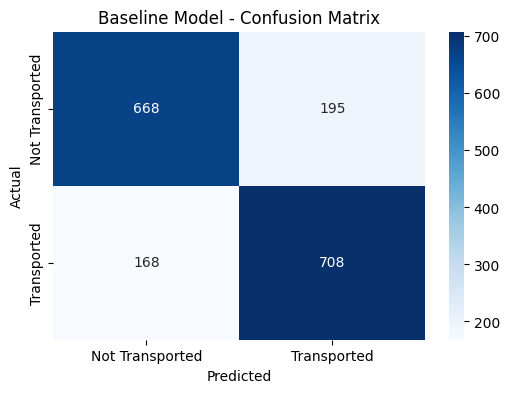

In [40]:
# Create baseline model - Logistic Regression
print("Training baseline Logistic Regression model...")

# Initialize and train model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Make predictions
y_pred_baseline = baseline_model.predict(X_val)
y_pred_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]

# Evaluate baseline model
baseline_accuracy = accuracy_score(y_val, y_pred_baseline)
baseline_auc = roc_auc_score(y_val, y_pred_proba_baseline)

print(f"Baseline Model Performance:")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"AUC-ROC: {baseline_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_baseline))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_baseline)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Transported', 'Transported'],
            yticklabels=['Not Transported', 'Transported'])
plt.title('Baseline Model - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Comparing multiple models...

Training Logistic Regression...
Logistic Regression - Accuracy: 0.7913, AUC-ROC: 0.8830

Training Random Forest...
Random Forest - Accuracy: 0.7982, AUC-ROC: 0.8949

Training XGBoost...
XGBoost - Accuracy: 0.8097, AUC-ROC: 0.9031

MODEL COMPARISON RESULTS
              Model  Accuracy  AUC-ROC
Logistic Regression  0.791259 0.882960
      Random Forest  0.798160 0.894878
            XGBoost  0.809661 0.903073


<Figure size 1000x600 with 0 Axes>

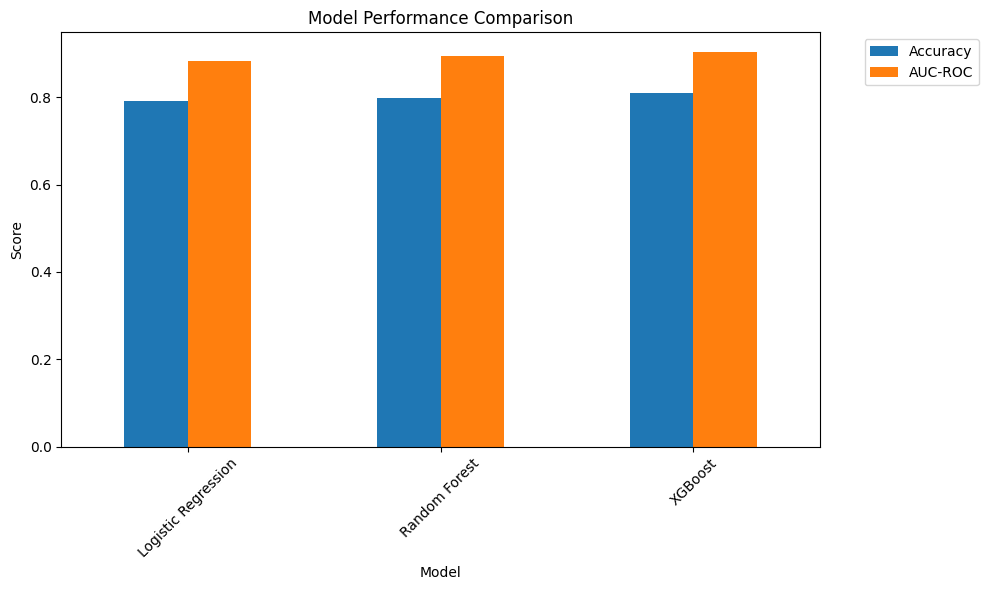

In [45]:
# Compare multiple models
print("Comparing multiple models...")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

model_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    model_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"{name} - Accuracy: {accuracy:.4f}, AUC-ROC: {auc:.4f}")

# Display results comparison
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [result['accuracy'] for result in model_results.values()],
    'AUC-ROC': [result['auc'] for result in model_results.values()]
})

print("\n" + "="*50)
print("MODEL COMPARISON RESULTS")
print("="*50)
print(results_df.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
results_df.set_index('Model').plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [46]:
# Hyperparameter tuning for the best model (XGBoost)
print("Performing hyperparameter tuning for XGBoost...")

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize model
xgb_model = XGBClassifier(random_state=42, eval_metric='logloss')

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get best model
best_xgb = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best model on validation set
y_pred_best = best_xgb.predict(X_val)
y_pred_proba_best = best_xgb.predict_proba(X_val)[:, 1]

best_accuracy = accuracy_score(y_val, y_pred_best)
best_auc = roc_auc_score(y_val, y_pred_proba_best)

print(f"\nTuned XGBoost Performance:")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"AUC-ROC: {best_auc:.4f}")

# Compare with baseline
improvement = best_accuracy - baseline_accuracy
print(f"\nImprovement over baseline: {improvement:.4f} ({improvement*100:.2f}%)")

Performing hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Best cross-validation score: 0.8099

Tuned XGBoost Performance:
Accuracy: 0.8074
AUC-ROC: 0.9104

Improvement over baseline: 0.0161 (1.61%)


Making final predictions on test set...
Created submission with 4277 predictions
Predicted distribution: {True: 2222, False: 2055}

Submission saved as 'submission.csv'

Sample predictions:
  PassengerId  Transported
0     0013_01        False
1     0018_01        False
2     0019_01         True
3     0021_01         True
4     0023_01        False
5     0027_01         True
6     0029_01         True
7     0032_01         True
8     0032_02         True
9     0033_01        False

Top 10 most important features:
               feature  importance
31           Has_Spent    0.684150
29           CryoSleep    0.068965
9               Deck_G    0.052869
0    HomePlanet_Europa    0.028303
7               Deck_E    0.019703
27  Luxury_Expenditure    0.017308
20           FoodCourt    0.017107
19         RoomService    0.016344
21        ShoppingMall    0.012520
12              Side_S    0.010483


<Figure size 1000x600 with 0 Axes>

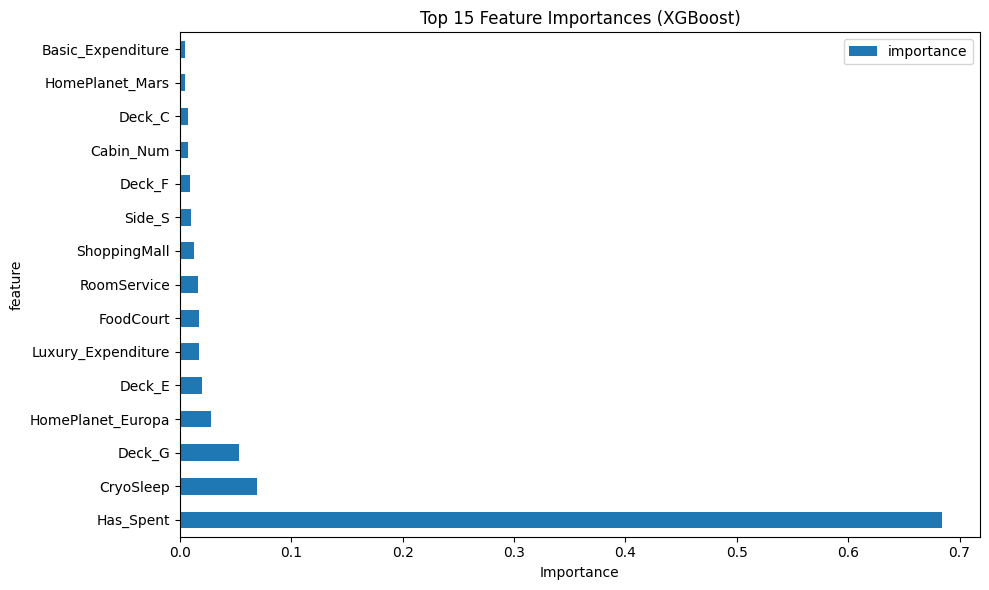


MODEL BUILDING COMPLETE!
Final Model: Tuned XGBoost
Validation Accuracy: 0.8074
Validation AUC-ROC: 0.9104
Submission file created: submission.csv


In [43]:
# Make final predictions on test set
print("Making final predictions on test set...")

# Use the best tuned model
final_predictions = best_xgb.predict(X_test)
final_probabilities = best_xgb.predict_proba(X_test)[:, 1]

# Create submission DataFrame
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': final_predictions.astype(bool)
})

print(f"Created submission with {len(submission)} predictions")
print(f"Predicted distribution: {submission['Transported'].value_counts().to_dict()}")

# Save submission file
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)
print(f"\nSubmission saved as '{submission_file}'")

# Display sample predictions
print("\nSample predictions:")
print(submission.head(10))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh', figsize=(10, 6))
plt.title('Top 15 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("MODEL BUILDING COMPLETE!")
print("="*60)
print(f"Final Model: Tuned XGBoost")
print(f"Validation Accuracy: {best_accuracy:.4f}")
print(f"Validation AUC-ROC: {best_auc:.4f}")
print(f"Submission file created: {submission_file}")
print("="*60)

In [47]:
# Display detailed classification report for the best model
print("Detailed Classification Report for Tuned XGBoost:")
print("=" * 60)
print(classification_report(y_val, y_pred_best, target_names=['Not Transported', 'Transported']))

# Calculate F1 scores specifically
from sklearn.metrics import f1_score, precision_score, recall_score

f1_macro = f1_score(y_val, y_pred_best, average='macro')
f1_weighted = f1_score(y_val, y_pred_best, average='weighted')
f1_class_0 = f1_score(y_val, y_pred_best, pos_label=0)
f1_class_1 = f1_score(y_val, y_pred_best, pos_label=1)

print("F1 Scores:")
print(f"F1 Macro Average: {f1_macro:.4f}")
print(f"F1 Weighted Average: {f1_weighted:.4f}")
print(f"F1 Score (Not Transported): {f1_class_0:.4f}")
print(f"F1 Score (Transported): {f1_class_1:.4f}")
print("=" * 60)

Detailed Classification Report for Tuned XGBoost:
                 precision    recall  f1-score   support

Not Transported       0.82      0.79      0.80       863
    Transported       0.80      0.83      0.81       876

       accuracy                           0.81      1739
      macro avg       0.81      0.81      0.81      1739
   weighted avg       0.81      0.81      0.81      1739

F1 Scores:
F1 Macro Average: 0.8072
F1 Weighted Average: 0.8073
F1 Score (Not Transported): 0.8019
F1 Score (Transported): 0.8125


In [55]:
# Strategy 1: Handle Class Imbalance with SMOTE
print("Strategy 1: Handling Class Imbalance with SMOTE")
print("-" * 50)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Check current class distribution
print("Current class distribution:")
print(y_train.value_counts())
print()

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(f"X_train shape: {X_train.shape} -> {X_train_smote.shape}")
print(f"y_train distribution: {y_train.value_counts().to_dict()}")
print(f"y_train_smote distribution: {y_train_smote.value_counts().to_dict()}")
print()

# Train XGBoost on SMOTE data
xgb_smote = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=3,
    n_estimators=100,
    subsample=1.0,
    random_state=42,
    eval_metric='logloss'
)

xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = xgb_smote.predict(X_val)

# Evaluate SMOTE model
smote_f1_macro = f1_score(y_val, y_pred_smote, average='macro')
smote_f1_weighted = f1_score(y_val, y_pred_smote, average='weighted')
smote_accuracy = accuracy_score(y_val, y_pred_smote)

print("SMOTE Model Performance:")
print(f"Accuracy: {smote_accuracy:.4f}")
print(f"F1 Macro: {smote_f1_macro:.4f}")
print(f"F1 Weighted: {smote_f1_weighted:.4f}")
print(f"Improvement in F1 Macro: {smote_f1_macro - f1_macro:.4f}")

Strategy 1: Handling Class Imbalance with SMOTE
--------------------------------------------------
Current class distribution:
Transported
True     3502
False    3452
Name: count, dtype: int64

After SMOTE:
X_train shape: (6954, 32) -> (7004, 32)
y_train distribution: {True: 3502, False: 3452}
y_train_smote distribution: {True: 3502, False: 3502}

SMOTE Model Performance:
Accuracy: 0.8097
F1 Macro: 0.8095
F1 Weighted: 0.8096
Improvement in F1 Macro: 0.0023


In [60]:
# Strategy 2: Advanced Feature Engineering
print("\nStrategy 2: Advanced Feature Engineering")
print("-" * 50)

# Start with the split processed data and add new features
X_train_feat = X_train.copy()
X_val_feat = X_val.copy()
X_test_feat = X_test.copy()

# Create interaction features that don't require original categorical columns
# Age and expenditure interactions
X_train_feat['Age_Expenditure_Interaction'] = X_train_feat['Age'] * X_train_feat['Total_Expenditure']
X_val_feat['Age_Expenditure_Interaction'] = X_val_feat['Age'] * X_val_feat['Total_Expenditure']
X_test_feat['Age_Expenditure_Interaction'] = X_test_feat['Age'] * X_test_feat['Total_Expenditure']

# Group size and VIP interaction
X_train_feat['Group_VIP_Interaction'] = X_train_feat['Group_Size'] * X_train_feat['VIP'].astype(int)
X_val_feat['Group_VIP_Interaction'] = X_val_feat['Group_Size'] * X_val_feat['VIP'].astype(int)
X_test_feat['Group_VIP_Interaction'] = X_test_feat['Group_Size'] * X_test_feat['VIP'].astype(int)

# CryoSleep and expenditure interaction
X_train_feat['CryoSleep_Expenditure'] = X_train_feat['CryoSleep'].astype(int) * X_train_feat['Total_Expenditure']
X_val_feat['CryoSleep_Expenditure'] = X_val_feat['CryoSleep'].astype(int) * X_val_feat['Total_Expenditure']
X_test_feat['CryoSleep_Expenditure'] = X_test_feat['CryoSleep'].astype(int) * X_test_feat['Total_Expenditure']

# Age and CryoSleep interaction
X_train_feat['Age_CryoSleep_Interaction'] = X_train_feat['Age'] * X_train_feat['CryoSleep'].astype(int)
X_val_feat['Age_CryoSleep_Interaction'] = X_val_feat['Age'] * X_val_feat['CryoSleep'].astype(int)
X_test_feat['Age_CryoSleep_Interaction'] = X_test_feat['Age'] * X_test_feat['CryoSleep'].astype(int)

# Expenditure ratios
X_train_feat['Luxury_Basic_Ratio'] = X_train_feat['Luxury_Expenditure'] / (X_train_feat['Basic_Expenditure'] + 1)  # +1 to avoid division by zero
X_val_feat['Luxury_Basic_Ratio'] = X_val_feat['Luxury_Expenditure'] / (X_val_feat['Basic_Expenditure'] + 1)
X_test_feat['Luxury_Basic_Ratio'] = X_test_feat['Luxury_Expenditure'] / (X_test_feat['Basic_Expenditure'] + 1)

print(f"Added {len(X_train_feat.columns) - len(X_train.columns)} new interaction features")

print(f"Total features: {X_train_feat.shape[1]}")

# Train model with new features
xgb_features = XGBClassifier(
    colsample_bytree=1.0,
    learning_rate=0.2,
    max_depth=3,
    n_estimators=100,
    subsample=1.0,
    random_state=42,
    eval_metric='logloss'
)

xgb_features.fit(X_train_feat, y_train)
y_pred_features = xgb_features.predict(X_val_feat)

# Evaluate feature engineering model
features_f1_macro = f1_score(y_val, y_pred_features, average='macro')
features_accuracy = accuracy_score(y_val, y_pred_features)

print("Feature Engineering Model Performance:")
print(f"Accuracy: {features_accuracy:.4f}")
print(f"F1 Macro: {features_f1_macro:.4f}")
print(f"Improvement in F1 Macro: {features_f1_macro - f1_macro:.4f}")


Strategy 2: Advanced Feature Engineering
--------------------------------------------------
Added 5 new interaction features
Total features: 37
Feature Engineering Model Performance:
Accuracy: 0.8108
F1 Macro: 0.8107
Improvement in F1 Macro: 0.0035


In [59]:
print("df_train columns:", df_train.columns.tolist())
print("df_test columns:", df_test.columns.tolist())

df_train columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']
df_test columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


In [62]:
# Output submission.csv
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)